In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with Claude 3 Models
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>                                                                                               <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

### Claude on Vertex AI

Anthropic Claude 3 models on Vertex AI offer fully managed and serverless models are offered as managed APIs. To use a Claude model on Vertex AI, send a request directly to the Vertex AI API endpoint.

You can stream your Claude responses to reduce the end-user latency perception. A streamed response uses server-sent events (SSE) to incrementally stream the response.

### Available Anthropic Claude models

#### Claude 3 Sonnet
Anthropic Claude 3 Sonnet provides a balance between intelligence and speed for enterprise workloads. It's a high-endurance model for scaled AI that's available at a competitive price.

#### Claude 3 Haiku
Anthropic Claude 3 Haiku is the fastest, most compact model available from Anthropic. It is designed to answer simple queries and requests quickly. You can use it to build AI experiences that mimic human interactions.

All Claude 3 models can process images and return text outputs, and feature a 200K context window.

## Objective

This notebook shows how to use **Vertex AI API** and **Anthropic’s Vertex SDK for Python** + against data from BQ dataset to call the Claude on Vertex AI API with the Claude 3 Sonnet and Claude 3 Haiku model.

For more information, see the [Use Claude](https://cloud.devsite.corp.google.com/vertex-ai/generative-ai/docs/third-party-models/use-claude) documentation.


### Getting Started


#### Authenticate your notebook environment (Colab only)
If you are running this notebook on Google Colab, uncomment and run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [14]:
# from google.colab import auth
# auth.authenticate_user()

## Using Anthropic's Vertex SDK + BQ for *Python*

### Getting Started


#### Install Anthropic's Vertex SDK for Python

In [15]:
! pip3 install -U 'anthropic[vertex]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.7/862.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.0 MB/s eta 0:00:00


#### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Select Claude 3 model

In [12]:
MODEL = "claude-3-sonnet@20240229"  # @param ["claude-3-sonnet@20240229", "claude-3-haiku@20240307"]
if MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-central1", "asia-southeast1"]
else:
    available_regions = ["us-central1", "europe-west4"]

#### Select a region

In [7]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a region:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global REGION
    if change["type"] == "change" and change["name"] == "value":
        REGION = change.new
        print("Selected:", change.new)


REGION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

Dropdown(description='Select a region:', options=('us-central1', 'asia-southeast1'), style=DescriptionStyle(de…

#### Define Google Cloud project and model information

In [8]:
PROJECT_ID = "cloud-llm-preview1"  # @param {type:"string"}
ENDPOINT = f"https://{REGION}-aiplatform.googleapis.com"

### Text generation for BQ Tables using Python DF


In [56]:
# @title Inspect the schema of BigQuery Table
from google.cloud import bigquery

# Construct a BigQuery client object.
client_bq = bigquery.Client()

# Fetch the table
table = client_bq.get_table('cloud-llm-preview1.ax_demo_bq_claude.objects')

# View table info
print("{} rows".format(table.num_rows))
for row in table.schema:
  print("Column {}: {}".format(row.name, row.field_type))

1000 rows
Column object_number: STRING
Column is_highlight: BOOLEAN
Column is_public_domain: BOOLEAN
Column object_id: INTEGER
Column department: STRING
Column object_name: STRING
Column title: STRING
Column culture: STRING
Column period: STRING
Column dynasty: STRING
Column reign: STRING
Column portfolio: STRING
Column artist_role: STRING
Column artist_prefix: STRING
Column artist_display_name: STRING
Column artist_display_bio: STRING
Column artist_suffix: STRING
Column artist_alpha_sort: STRING
Column artist_nationality: STRING
Column artist_begin_date: STRING
Column artist_end_date: STRING
Column object_date: STRING
Column object_begin_date: INTEGER
Column object_end_date: INTEGER
Column medium: STRING
Column dimensions: STRING
Column credit_line: STRING
Column geography_type: STRING
Column city: STRING
Column state: STRING
Column county: STRING
Column country: STRING
Column region: STRING
Column subregion: STRING
Column locale: STRING
Column locus: STRING
Column excavation: STRING


In [44]:
# @title prompt: select top 10 records from table and put into dataframe

df = client_bq.query("""
SELECT
  object_id, title
FROM
  `cloud-llm-preview1.ax_demo_bq_claude.objects` limit 10;
""").to_dataframe()
df.head(10)

object_id                                              title
0      44294  大理石插屏|Table Screen, now converted to a wall panel
1      64029         唐 颜真卿 顏家廟碑 現代拓片 紙本|Yan Family Temple Stele
2      40017         清 十八世紀顧二娘款鳳紋硯|Inkstone with phoenix design
3     684605                        十七/十八世紀 銅錯銀絲題竇常詩文饕餮耳方壺|Vase
4      39899          東晉 王羲之 十七日帖 十三世紀拓本|On the Seventeenth Day
5      64046  張旭 「肚痛帖」; 懷素 「寄邊衣」詩|Ji bianyi|Letter about a S...
6      44864    白繻子地墨竹図打掛　祇園南海筆|Overrobe (Uchikake) with Bamboo
7     711870                                    不動明王像|Fudō Myōō
8      62167                            掛花籃|Large Flower Basket
9      60501  菊紋楓枝文七宝瓶　（一対）|Imperial Presentation Vase with ...

In [45]:
# Call Claude on Vertex Client

from anthropic import AnthropicVertex

client_llm = AnthropicVertex(region=REGION, project_id=PROJECT_ID)

In [46]:
# Use Claude the Translate the Title Column
for index, row in df.iterrows():
    message = client_llm.messages.create(
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": "translate this into English: " + row['title'],
            }
        ],
        model=MODEL,
    )
    df.at[index, 'description'] = message.content

In [51]:
# prompt: change the description column into string formate

df['description'] = df['description'].astype(str)

In [52]:
df.head(10)

object_id                                              title  \
0      44294  大理石插屏|Table Screen, now converted to a wall panel   
1      64029         唐 颜真卿 顏家廟碑 現代拓片 紙本|Yan Family Temple Stele   
2      40017         清 十八世紀顧二娘款鳳紋硯|Inkstone with phoenix design   
3     684605                        十七/十八世紀 銅錯銀絲題竇常詩文饕餮耳方壺|Vase   
4      39899          東晉 王羲之 十七日帖 十三世紀拓本|On the Seventeenth Day   
5      64046  張旭 「肚痛帖」; 懷素 「寄邊衣」詩|Ji bianyi|Letter about a S...   
6      44864    白繻子地墨竹図打掛　祇園南海筆|Overrobe (Uchikake) with Bamboo   
7     711870                                    不動明王像|Fudō Myōō   
8      62167                            掛花籃|Large Flower Basket   
9      60501  菊紋楓枝文七宝瓶　（一対）|Imperial Presentation Vase with ...   

                                         description  
0  TextBlock(text='Here is the translation into E...  
1  [TextBlock(text='Here is the translation into ...  
2  [TextBlock(text='English translation: Qing 18t...  
3  [TextBlock(text='Here is the translation to En...  
4  [TextBlock(text='Here is the translation into ...  
5  [TextBlock(text='Here is my attempt at an Engl...  
6  [TextBlock(text='The Japanese text describes a...  
7  [TextBlock(text='Fudō Myōō is the Japanese nam...  
8  [TextBlock(text='The translation of "掛花籃" into...  
9  [TextBlock(text='This is the English translati...

In [42]:
# prompt: load the dataframe output to another Bigquery table

# @title Save results to BigQuery

# Construct a BigQuery client object.
client_bq = bigquery.Client()

# Construct a full BigQuery table ID to save the results.
dataset_ref = bigquery.DatasetReference(PROJECT_ID, "ax_demo_bq_claude")
table_ref = dataset_ref.table("claude_translations")

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("object_id", "Int64"),
        bigquery.SchemaField("title", "STRING"),
        bigquery.SchemaField("description", "STRING"),
    ],
)

job = client_bq.load_table_from_dataframe(
    df, table_ref, job_config=job_config
)  # Make an API request.

job.result()  # Waits for the job to complete.

table = client_bq.get_table(table_ref)
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_ref
    )
)

Loaded 10 rows and 3 columns to cloud-llm-preview1.ax_demo_bq_claude.claude_translations


In [53]:
%%bigquery
ALTER TABLE `cloud-llm-preview1.ax_demo_bq_claude.objects`
ADD COLUMN description STRING;

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [55]:
%%bigquery
UPDATE `cloud-llm-preview1.ax_demo_bq_claude.objects` AS table_A
SET description = table_B.description
FROM `cloud-llm-preview1.ax_demo_bq_claude.claude_translations` AS table_B
WHERE table_A.object_id = table_B.object_id;

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

### Vision

--2024-05-22 16:50:12--  https://images.metmuseum.org/CRDImages/as/original/DP328602.jpg
Resolving images.metmuseum.org (images.metmuseum.org)... 45.60.77.20
Connecting to images.metmuseum.org (images.metmuseum.org)|45.60.77.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3110944 (3.0M) [image/jpeg]
Saving to: ‘DP328602.jpg’

DP328602.jpg        100%[===================>]   2.97M  1.14MB/s    in 2.6s    

2024-05-22 16:50:15 (1.14 MB/s) - ‘DP328602.jpg’ saved [3110944/3110944]



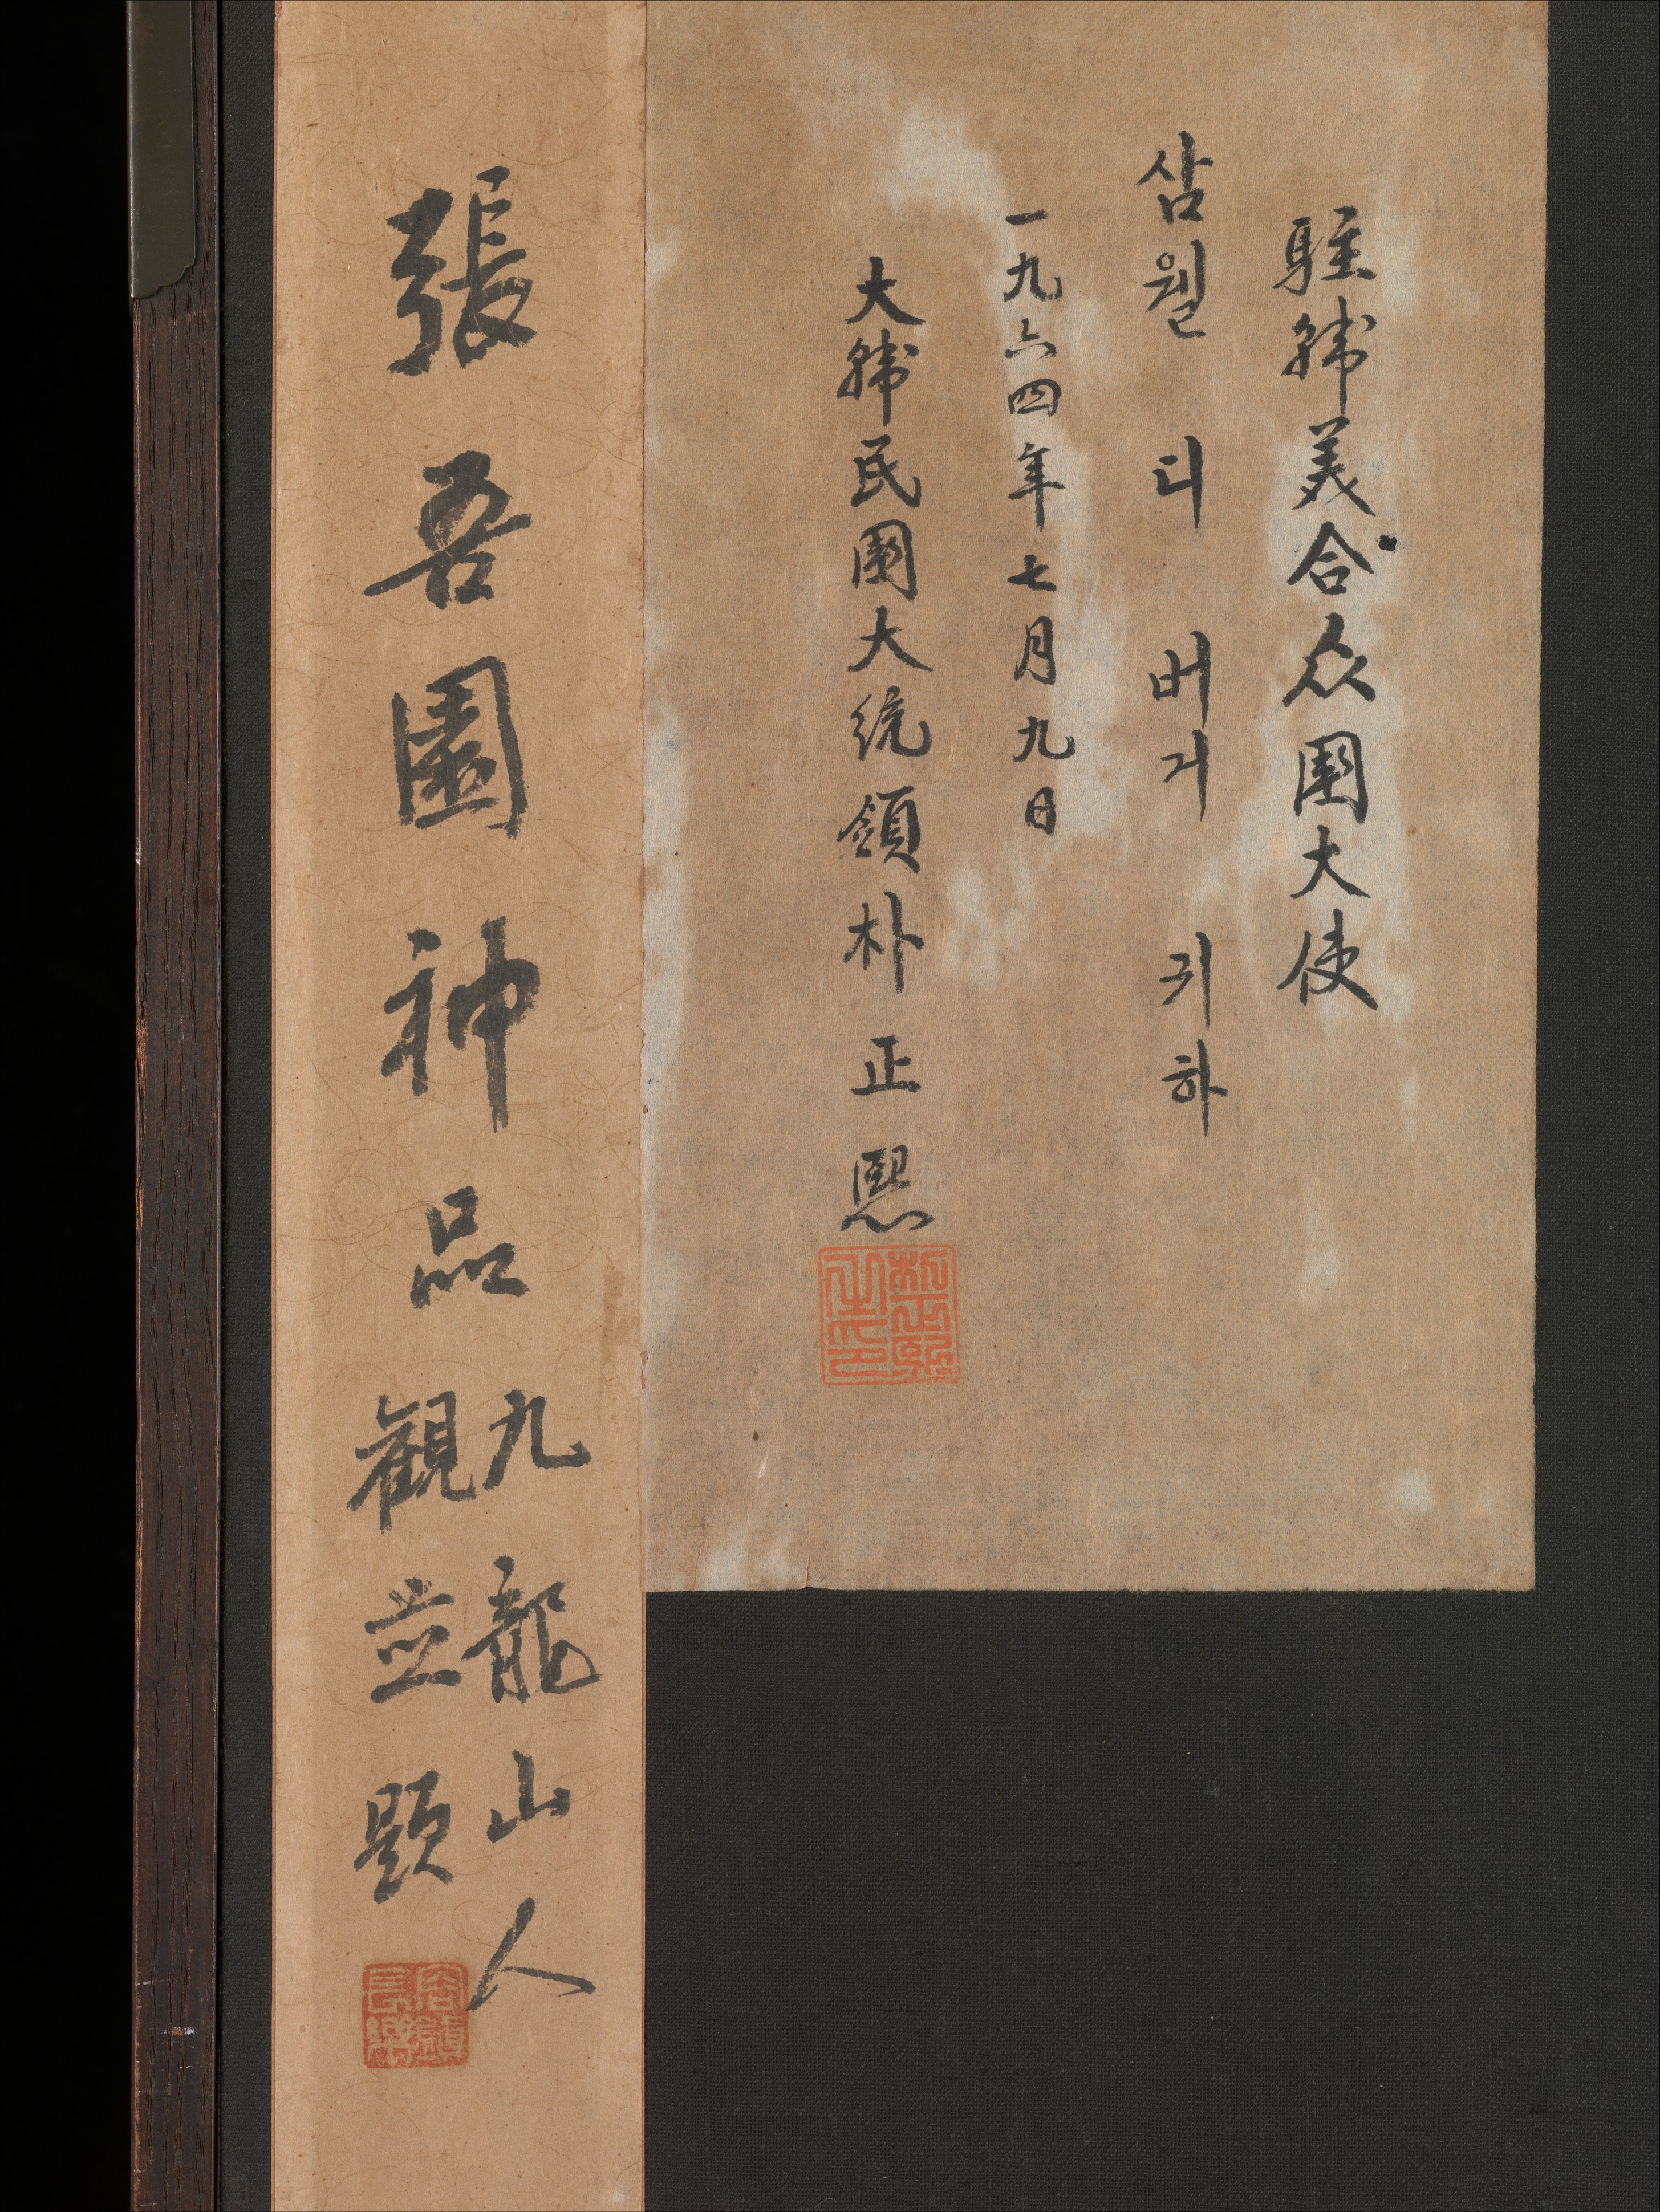

In [ ]:
# prompt: display the image from this url: https://images.metmuseum.org/CRDImages/as/original/DP328602.jpg

!wget https://images.metmuseum.org/CRDImages/as/original/DP328602.jpg
from IPython.display import Image
Image('DP328602.jpg')

In [ ]:
import base64

import httpx
from anthropic import AnthropicVertex

client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)

image1_url = "https://images.metmuseum.org/CRDImages/as/original/DP328602.jpg"
image1_media_type = "image/jpeg"
image1_data = base64.b64encode(httpx.get(image1_url).content).decode("utf-8")

message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {"type": "text", "text": "Describe in this image."},
            ],
        }
    ],
    model=MODEL,
)
print(message.model_dump_json(indent=2))

{
  "id": "msg_vrtx_01S51rYFaBeQuFQ4gtjZiXiu",
  "content": [
    {
      "text": "This image appears to be an antique document or book page written in Chinese calligraphy or brush writing. The text and calligraphic writing are rendered in black ink on an aged, tan or brown paper surface.\n\nThe calligraphy consists of various Chinese characters and symbols written in different styles and sizes, likely representing titles, names, or poetic phrases. Some larger characters stand out prominently at the top and side areas.\n\nThere are also two small red stamp or seal impressions visible, which were commonly used as signatures or marks of authorship or ownership on historical Asian artworks and documents.\n\nWhile I cannot identify any specific individuals depicted, the aged appearance and traditional calligraphic writing style suggest this is an antiquarian piece or preserved page from a classical Chinese manuscript or text from centuries past.",
      "type": "text"
    }
  ],
  "model":

### BigQuery BigFrame Test

In [57]:
import bigframes.pandas as bpd

# Set BigQuery DataFrames options
bpd.options.bigquery.project = PROJECT_ID


In [58]:
# read table
query="""
SELECT * FROM `cloud-llm-preview1.ax_demo_bq_claude.claude_translations`
"""
bq_df = bpd.read_gbq(query)
bq_df=bq_df[["object_id","title"]].head(10)
bq_df

# df_2=bpd.read_gbq("cloud-llm-preview1.the_met_public_domain_art_works.objects")
# df_2.head(10)


object_id                                              title
0      65620                          清  倣龔賢  山水圖  冊|Landscapes
1      49665                            近代  丁輔之  荔枝  扇面|Lychees
2      40445               이유원, 매화도  조선|李裕元 梅花圖  朝鮮|Plum Branch
3      36130  清  倣龔賢  十二月令山水圖  冊|Landscapes of the Twelve Mo...
4      77916  석지 채용신    학자 초상|石芝 蔡龍臣 學者肖像|Portrait of a scholar
5      49133  清  倣龔賢  雲山隱居圖  軸|Dwelling among Mountains and ...
6      64046  張旭 「肚痛帖」; 懷素 「寄邊衣」詩|Ji bianyi|Letter about a S...
7      36072                   清  程正揆  江山臥遊圖  卷|Dream Landscape
8     646996  전(傳) 오원 장승업 (1843–1897) 청동기와 화초가 있는 정물화 조선|傳 吾...
9      39899          東晉 王羲之 十七日帖 十三世紀拓本|On the Seventeenth Day

[10 rows x 2 columns]